# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy - Modified: tech indicator

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
# install finrl library
# !git clone https://github.com/AI4Finance-LLC/FinRL-Library.git

In [2]:
import sys
sys.path.append("FinRL-Library")

In [3]:
# install packages
# !pip install yfinance

In [4]:
# !pip install stockstats

In [5]:
# !pip install git+https://github.com/quantopian/pyfolio

In [6]:
# ## install finrl library
#!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.apps import config
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [9]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [10]:
# from config.py start_date is a string
config.START_DATE

'2009-01-01'

In [11]:
print(config.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [12]:
# I changed the end datae to yesterday, original date is 2021-07-06
df = YahooDownloader(start_date = '1998-01-01',
                     end_date = '2022-03-21',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [13]:
df.head()

,date,open,high,low,close,volume,tic,day
0,1998-01-02,0.121652,0.145089,0.120536,0.124236,718110400.0,AAPL,4
1,1998-01-02,13.515625,13.531250,13.343750,10.338571,4234800.0,AMGN,4
2,1998-01-02,25.967234,25.967234,25.766644,18.672760,3085685.0,AXP,4
3,1998-01-02,48.937500,49.812500,48.125000,30.740921,2761300.0,BA,4
4,1998-01-02,24.250000,24.500000,24.250000,12.989574,1345000.0,CAT,4


In [14]:
df.tail()

,date,open,high,low,close,volume,tic,day
172921,2022-03-18,508.739990,510.679993,501.559998,506.119995,5059000.0,UNH,4
172922,2022-03-18,211.699997,219.259995,210.289993,219.110001,14608100.0,V,4
172923,2022-03-18,52.119999,52.290001,50.799999,50.799999,70348600.0,VZ,4
172924,2022-03-18,47.349998,47.450001,46.470001,47.360001,11368000.0,WBA,4
172925,2022-03-18,145.179993,145.570007,144.110001,145.440002,10407600.0,WMT,4


In [15]:
df.shape

(172926, 8)

In [16]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,1998-01-02,0.121652,0.145089,0.120536,0.124236,718110400.0,AAPL,4
1,1998-01-02,13.515625,13.531250,13.343750,10.338571,4234800.0,AMGN,4
2,1998-01-02,25.967234,25.967234,25.766644,18.672760,3085685.0,AXP,4
3,1998-01-02,48.937500,49.812500,48.125000,30.740921,2761300.0,BA,4
4,1998-01-02,24.250000,24.500000,24.250000,12.989574,1345000.0,CAT,4


In [17]:
len(df.tic.unique())

30

In [18]:
df.tic.value_counts()

AAPL    6093
KO      6093
WMT     6093
WBA     6093
VZ      6093
UNH     6093
TRV     6093
PG      6093
NKE     6093
MSFT    6093
MRK     6093
MMM     6093
AMGN    6093
MCD     6093
JPM     6093
JNJ     6093
INTC    6093
IBM     6093
HON     6093
HD      6093
DIS     6093
CVX     6093
CSCO    6093
CAT     6093
BA      6093
AXP     6093
GS      5758
CRM     4467
V       3526
DOW      757
Name: tic, dtype: int64

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [19]:
# added indicators
tech_indicators = [    #"boll_ub", "boll_lb", # this two are new
'macd',
 'rsi_30',
 'cci_30',
 'dx_30']

In [20]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = tech_indicators,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [21]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence
107958,2014-07-07,130.440002,130.639999,130.020004,92.967049,3660000.0,CVX,0,1.201944,62.718098,61.133396,21.201198,20.998395
36304,2003-07-24,32.160000,32.470001,31.459999,20.522646,7095400.0,HD,3,-0.055730,50.053931,-144.271684,13.390456,13.377719
34614,2003-04-22,27.219999,27.750000,27.080000,17.992540,9557200.0,HD,1,0.618455,61.890209,120.252959,41.804052,15.473996
78027,2009-12-07,57.320000,57.450001,56.330002,43.303642,6061300.0,AMGN,0,0.128463,48.968008,82.495172,1.369783,12.941842
136441,2018-11-07,76.940002,78.230003,76.570000,75.457558,5403900.0,NKE,2,-0.698476,50.143149,4.703771,4.792758,30.265696


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [22]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(tech_indicators)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 26, State Space: 157


In [23]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicators,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [24]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)
train_start = '1998-01-01'
train_end = '2018-12-01' #original is 2020-4-1
val_test_start = '2018-12-01' #original is 2020-4-1
val_test_end = '2022-03-21'#original is 2021-7-06

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(train_start,train_end),
                 val_test_period=(val_test_start,val_test_end),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)

In [25]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.01,
                    'learning_rate': 0.0005
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 64
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 100_000,
                      "learning_rate": 0.000005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 30_000, 
                 'ppo' : 100_000, 
                 'ddpg' : 10_000
                 }


timesteps_dict = {'a2c' : 10_000, 
                 'ppo' : 10_000, 
                 'ddpg' : 10_000
                 }

In [26]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  164.4792476874577
======Model training from:  1998-01-01 to  2018-12-03
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_26
-------------------------------------
| time/                 |           |
|    fps                | 43        |
|    iterations         | 100       |
|    time_elapsed       | 11        |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -37.1     |
|    explained_variance | -0.103    |
|    learning_rate      | 0.0005    |
|    n_updates          | 99        |
|    policy_loss        | 102       |
|    reward             | 0.6890273 |
|    std                | 1.01      |
|    value_loss         | 17.2      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 57 

---------------------------------------
| time/                 |             |
|    fps                | 81          |
|    iterations         | 1400        |
|    time_elapsed       | 85          |
|    total_timesteps    | 7000        |
| train/                |             |
|    entropy_loss       | -37.2       |
|    explained_variance | -0.171      |
|    learning_rate      | 0.0005      |
|    n_updates          | 1399        |
|    policy_loss        | -84         |
|    reward             | -0.46193358 |
|    std                | 1.01        |
|    value_loss         | 5.76        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 82         |
|    iterations         | 1500       |
|    time_elapsed       | 91         |
|    total_timesteps    | 7500       |
| train/                |            |
|    entropy_loss       | -37.2      |
|    explained_variance | -0.00363   |
|    lear

======PPO Validation from:  2018-12-03 to  2019-03-07
PPO Sharpe Ratio:  0.06417981088584192
======DDPG Training========
{'buffer_size': 100000, 'learning_rate': 5e-06, 'batch_size': 64}
Using cpu device
Logging to tensorboard_log/ddpg/ddpg_126_18
day: 5263, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 8772195.08
total_reward: 7772195.08
total_cost: 4011.94
total_trades: 63591
Sharpe: 0.613
======DDPG Validation from:  2018-12-03 to  2019-03-07
======Best Model Retraining from:  1998-01-01 to  2019-03-07
======Trading from:  2019-03-07 to  2019-06-06
turbulence_threshold:  164.4792476874577
======Model training from:  1998-01-01 to  2019-03-07
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_189_19
-------------------------------------
| time/                 |           |
|    fps                | 86        |
|    iterations         | 100       |
|    time_elapsed       | 5         |
|

-------------------------------------
| time/                 |           |
|    fps                | 87        |
|    iterations         | 1300      |
|    time_elapsed       | 74        |
|    total_timesteps    | 6500      |
| train/                |           |
|    entropy_loss       | -37.2     |
|    explained_variance | -0.119    |
|    learning_rate      | 0.0005    |
|    n_updates          | 1299      |
|    policy_loss        | -61.7     |
|    reward             | 1.4467568 |
|    std                | 1.01      |
|    value_loss         | 3.2       |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 87         |
|    iterations         | 1400       |
|    time_elapsed       | 80         |
|    total_timesteps    | 7000       |
| train/                |            |
|    entropy_loss       | -37.2      |
|    explained_variance | 0          |
|    learning_rate      | 0.0005     |
| 

======PPO Validation from:  2019-03-07 to  2019-06-06
PPO Sharpe Ratio:  -0.20728432689057727
======DDPG Training========
{'buffer_size': 100000, 'learning_rate': 5e-06, 'batch_size': 64}
Using cpu device
Logging to tensorboard_log/ddpg/ddpg_189_18
day: 5326, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 8953692.79
total_reward: 7953692.79
total_cost: 4039.30
total_trades: 75913
Sharpe: 0.642
======DDPG Validation from:  2019-03-07 to  2019-06-06
======Best Model Retraining from:  1998-01-01 to  2019-06-06
======Trading from:  2019-06-06 to  2019-09-05
turbulence_threshold:  164.4792476874577
======Model training from:  1998-01-01 to  2019-06-06
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_252_18
-------------------------------------
| time/                 |           |
|    fps                | 82        |
|    iterations         | 100       |
|    time_elapsed       | 6         |


------------------------------------
| time/                 |          |
|    fps                | 84       |
|    iterations         | 1300     |
|    time_elapsed       | 76       |
|    total_timesteps    | 6500     |
| train/                |          |
|    entropy_loss       | -36.9    |
|    explained_variance | 0.00541  |
|    learning_rate      | 0.0005   |
|    n_updates          | 1299     |
|    policy_loss        | -123     |
|    reward             | 1.750282 |
|    std                | 1        |
|    value_loss         | 11.9     |
------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 84         |
|    iterations         | 1400       |
|    time_elapsed       | 82         |
|    total_timesteps    | 7000       |
| train/                |            |
|    entropy_loss       | -36.9      |
|    explained_variance | 0.0293     |
|    learning_rate      | 0.0005     |
|    n_updates    

======PPO Validation from:  2019-06-06 to  2019-09-05
PPO Sharpe Ratio:  -0.12549346976410125
======DDPG Training========
{'buffer_size': 100000, 'learning_rate': 5e-06, 'batch_size': 64}
Using cpu device
Logging to tensorboard_log/ddpg/ddpg_252_17
day: 5389, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 6512794.85
total_reward: 5512794.85
total_cost: 3509.69
total_trades: 70471
Sharpe: 0.513
======DDPG Validation from:  2019-06-06 to  2019-09-05
======Best Model Retraining from:  1998-01-01 to  2019-09-05
======Trading from:  2019-09-05 to  2019-12-04
turbulence_threshold:  164.4792476874577
======Model training from:  1998-01-01 to  2019-09-05
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_315_16
-------------------------------------
| time/                 |           |
|    fps                | 81        |
|    iterations         | 100       |
|    time_elapsed       | 6         |


-------------------------------------
| time/                 |           |
|    fps                | 86        |
|    iterations         | 1300      |
|    time_elapsed       | 75        |
|    total_timesteps    | 6500      |
| train/                |           |
|    entropy_loss       | -37.1     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 1299      |
|    policy_loss        | 59.9      |
|    reward             | 1.1419225 |
|    std                | 1.01      |
|    value_loss         | 3.98      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 86        |
|    iterations         | 1400      |
|    time_elapsed       | 81        |
|    total_timesteps    | 7000      |
| train/                |           |
|    entropy_loss       | -37.1     |
|    explained_variance | -0.927    |
|    learning_rate      | 0.0005    |
|    n_updat

======PPO Validation from:  2019-09-05 to  2019-12-04
PPO Sharpe Ratio:  0.06087723806046062
======DDPG Training========
{'buffer_size': 100000, 'learning_rate': 5e-06, 'batch_size': 64}
Using cpu device
Logging to tensorboard_log/ddpg/ddpg_315_14
day: 5452, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 6621773.90
total_reward: 5621773.90
total_cost: 6033.42
total_trades: 92294
Sharpe: 0.551
======DDPG Validation from:  2019-09-05 to  2019-12-04
======Best Model Retraining from:  1998-01-01 to  2019-12-04
======Trading from:  2019-12-04 to  2020-03-06
turbulence_threshold:  164.4792476874577
======Model training from:  1998-01-01 to  2019-12-04
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_378_2
--------------------------------------
| time/                 |            |
|    fps                | 84         |
|    iterations         | 100        |
|    time_elapsed       | 5         

--------------------------------------
| time/                 |            |
|    fps                | 85         |
|    iterations         | 1300       |
|    time_elapsed       | 75         |
|    total_timesteps    | 6500       |
| train/                |            |
|    entropy_loss       | -37.2      |
|    explained_variance | -0.928     |
|    learning_rate      | 0.0005     |
|    n_updates          | 1299       |
|    policy_loss        | 26.4       |
|    reward             | -1.0941073 |
|    std                | 1.01       |
|    value_loss         | 1.18       |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 86          |
|    iterations         | 1400        |
|    time_elapsed       | 81          |
|    total_timesteps    | 7000        |
| train/                |             |
|    entropy_loss       | -37.2       |
|    explained_variance | -0.00772    |
|    learning_ra

======PPO Validation from:  2019-12-04 to  2020-03-06
PPO Sharpe Ratio:  -0.2450918198617352
======DDPG Training========
{'buffer_size': 100000, 'learning_rate': 5e-06, 'batch_size': 64}
Using cpu device
Logging to tensorboard_log/ddpg/ddpg_378_2
day: 5515, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 6327936.94
total_reward: 5327936.94
total_cost: 3937.98
total_trades: 84426
Sharpe: 0.584
======DDPG Validation from:  2019-12-04 to  2020-03-06
======Best Model Retraining from:  1998-01-01 to  2020-03-06
======Trading from:  2020-03-06 to  2020-06-05
turbulence_threshold:  164.4792476874577
======Model training from:  1998-01-01 to  2020-03-06
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_441_2
-------------------------------------
| time/                 |           |
|    fps                | 83        |
|    iterations         | 100       |
|    time_elapsed       | 5         |
|  

-------------------------------------
| time/                 |           |
|    fps                | 84        |
|    iterations         | 1300      |
|    time_elapsed       | 76        |
|    total_timesteps    | 6500      |
| train/                |           |
|    entropy_loss       | -37.1     |
|    explained_variance | 1.19e-07  |
|    learning_rate      | 0.0005    |
|    n_updates          | 1299      |
|    policy_loss        | -112      |
|    reward             | -2.329872 |
|    std                | 1.01      |
|    value_loss         | 10.6      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 85         |
|    iterations         | 1400       |
|    time_elapsed       | 82         |
|    total_timesteps    | 7000       |
| train/                |            |
|    entropy_loss       | -37.1      |
|    explained_variance | -1.19e-07  |
|    learning_rate      | 0.0005     |
| 

======PPO Validation from:  2020-03-06 to  2020-06-05
PPO Sharpe Ratio:  0.20034308287477287
======DDPG Training========
{'buffer_size': 100000, 'learning_rate': 5e-06, 'batch_size': 64}
Using cpu device
Logging to tensorboard_log/ddpg/ddpg_441_2
day: 5578, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 7320248.55
total_reward: 6320248.55
total_cost: 5246.82
total_trades: 50745
Sharpe: 0.574
======DDPG Validation from:  2020-03-06 to  2020-06-05
======Best Model Retraining from:  1998-01-01 to  2020-06-05
======Trading from:  2020-06-05 to  2020-09-03
turbulence_threshold:  164.4792476874577
======Model training from:  1998-01-01 to  2020-06-05
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_504_2
-------------------------------------
| time/                 |           |
|    fps                | 82        |
|    iterations         | 100       |
|    time_elapsed       | 6         |
|  

--------------------------------------
| time/                 |            |
|    fps                | 81         |
|    iterations         | 1300       |
|    time_elapsed       | 79         |
|    total_timesteps    | 6500       |
| train/                |            |
|    entropy_loss       | -37.2      |
|    explained_variance | 0          |
|    learning_rate      | 0.0005     |
|    n_updates          | 1299       |
|    policy_loss        | 117        |
|    reward             | -1.4676365 |
|    std                | 1.01       |
|    value_loss         | 11.6       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 82        |
|    iterations         | 1400      |
|    time_elapsed       | 85        |
|    total_timesteps    | 7000      |
| train/                |           |
|    entropy_loss       | -37.2     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005  

======PPO Validation from:  2020-06-05 to  2020-09-03
PPO Sharpe Ratio:  0.31770586905205744
======DDPG Training========
{'buffer_size': 100000, 'learning_rate': 5e-06, 'batch_size': 64}
Using cpu device
Logging to tensorboard_log/ddpg/ddpg_504_2
day: 5641, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 6206449.97
total_reward: 5206449.97
total_cost: 3667.76
total_trades: 85978
Sharpe: 0.506
======DDPG Validation from:  2020-06-05 to  2020-09-03
======Best Model Retraining from:  1998-01-01 to  2020-09-03
======Trading from:  2020-09-03 to  2020-12-03
turbulence_threshold:  164.4792476874577
======Model training from:  1998-01-01 to  2020-09-03
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_567_2
--------------------------------------
| time/                 |            |
|    fps                | 82         |
|    iterations         | 100        |
|    time_elapsed       | 6          

--------------------------------------
| time/                 |            |
|    fps                | 83         |
|    iterations         | 1300       |
|    time_elapsed       | 77         |
|    total_timesteps    | 6500       |
| train/                |            |
|    entropy_loss       | -37.1      |
|    explained_variance | -1.19e-07  |
|    learning_rate      | 0.0005     |
|    n_updates          | 1299       |
|    policy_loss        | -161       |
|    reward             | -1.4081041 |
|    std                | 1.01       |
|    value_loss         | 21         |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 83         |
|    iterations         | 1400       |
|    time_elapsed       | 83         |
|    total_timesteps    | 7000       |
| train/                |            |
|    entropy_loss       | -37.1      |
|    explained_variance | 0          |
|    learning_rate      |

======PPO Validation from:  2020-09-03 to  2020-12-03
PPO Sharpe Ratio:  0.21133342985425593
======DDPG Training========
{'buffer_size': 100000, 'learning_rate': 5e-06, 'batch_size': 64}
Using cpu device
Logging to tensorboard_log/ddpg/ddpg_567_2
day: 5704, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 5164293.74
total_reward: 4164293.74
total_cost: 4185.89
total_trades: 69660
Sharpe: 0.423
======DDPG Validation from:  2020-09-03 to  2020-12-03
======Best Model Retraining from:  1998-01-01 to  2020-12-03
======Trading from:  2020-12-03 to  2021-03-08
turbulence_threshold:  164.4792476874577
======Model training from:  1998-01-01 to  2020-12-03
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_630_2
-------------------------------------
| time/                 |           |
|    fps                | 80        |
|    iterations         | 100       |
|    time_elapsed       | 6         |
|  

--------------------------------------
| time/                 |            |
|    fps                | 82         |
|    iterations         | 1400       |
|    time_elapsed       | 85         |
|    total_timesteps    | 7000       |
| train/                |            |
|    entropy_loss       | -37.2      |
|    explained_variance | -0.0546    |
|    learning_rate      | 0.0005     |
|    n_updates          | 1399       |
|    policy_loss        | -25.6      |
|    reward             | -0.8361775 |
|    std                | 1.01       |
|    value_loss         | 3.13       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 82        |
|    iterations         | 1500      |
|    time_elapsed       | 91        |
|    total_timesteps    | 7500      |
| train/                |           |
|    entropy_loss       | -37.2     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005  

======PPO Validation from:  2020-12-03 to  2021-03-08
PPO Sharpe Ratio:  0.14025231985688177
======DDPG Training========
{'buffer_size': 100000, 'learning_rate': 5e-06, 'batch_size': 64}
Using cpu device
Logging to tensorboard_log/ddpg/ddpg_630_2
day: 5767, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 5863140.40
total_reward: 4863140.40
total_cost: 3832.33
total_trades: 76538
Sharpe: 0.496
======DDPG Validation from:  2020-12-03 to  2021-03-08
======Best Model Retraining from:  1998-01-01 to  2021-03-08
======Trading from:  2021-03-08 to  2021-06-07
turbulence_threshold:  164.4792476874577
======Model training from:  1998-01-01 to  2021-03-08
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_693_2
-------------------------------------
| time/                 |           |
|    fps                | 80        |
|    iterations         | 100       |
|    time_elapsed       | 6         |
|  

--------------------------------------
| time/                 |            |
|    fps                | 81         |
|    iterations         | 1300       |
|    time_elapsed       | 79         |
|    total_timesteps    | 6500       |
| train/                |            |
|    entropy_loss       | -36.9      |
|    explained_variance | -2.38e-07  |
|    learning_rate      | 0.0005     |
|    n_updates          | 1299       |
|    policy_loss        | -126       |
|    reward             | -2.3220506 |
|    std                | 1          |
|    value_loss         | 17.1       |
--------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 81          |
|    iterations         | 1400        |
|    time_elapsed       | 85          |
|    total_timesteps    | 7000        |
| train/                |             |
|    entropy_loss       | -37         |
|    explained_variance | 0           |
|    learning_ra

======PPO Validation from:  2021-03-08 to  2021-06-07
PPO Sharpe Ratio:  0.25705709051642434
======DDPG Training========
{'buffer_size': 100000, 'learning_rate': 5e-06, 'batch_size': 64}
Using cpu device
Logging to tensorboard_log/ddpg/ddpg_693_2
day: 5830, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 7670020.72
total_reward: 6670020.72
total_cost: 4131.88
total_trades: 100092
Sharpe: 0.576
======DDPG Validation from:  2021-03-08 to  2021-06-07
======Best Model Retraining from:  1998-01-01 to  2021-06-07
======Trading from:  2021-06-07 to  2021-09-03
turbulence_threshold:  164.4792476874577
======Model training from:  1998-01-01 to  2021-06-07
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_756_2
--------------------------------------
| time/                 |            |
|    fps                | 79         |
|    iterations         | 100        |
|    time_elapsed       | 6         

-------------------------------------
| time/                 |           |
|    fps                | 81        |
|    iterations         | 1300      |
|    time_elapsed       | 80        |
|    total_timesteps    | 6500      |
| train/                |           |
|    entropy_loss       | -37.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 1299      |
|    policy_loss        | -108      |
|    reward             | 2.2554734 |
|    std                | 1.01      |
|    value_loss         | 9.95      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 80         |
|    iterations         | 1400       |
|    time_elapsed       | 86         |
|    total_timesteps    | 7000       |
| train/                |            |
|    entropy_loss       | -37.2      |
|    explained_variance | 0          |
|    learning_rate      | 0.0005     |
| 

======PPO Validation from:  2021-06-07 to  2021-09-03
PPO Sharpe Ratio:  0.1562881431971876
======DDPG Training========
{'buffer_size': 100000, 'learning_rate': 5e-06, 'batch_size': 64}
Using cpu device
Logging to tensorboard_log/ddpg/ddpg_756_2
day: 5893, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 8274050.91
total_reward: 7274050.91
total_cost: 3870.21
total_trades: 78666
Sharpe: 0.534
======DDPG Validation from:  2021-06-07 to  2021-09-03
======Best Model Retraining from:  1998-01-01 to  2021-09-03
======Trading from:  2021-09-03 to  2021-12-03
turbulence_threshold:  164.4792476874577
======Model training from:  1998-01-01 to  2021-09-03
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_819_2
---------------------------------------
| time/                 |             |
|    fps                | 77          |
|    iterations         | 100         |
|    time_elapsed       | 6       

--------------------------------------
| time/                 |            |
|    fps                | 79         |
|    iterations         | 1300       |
|    time_elapsed       | 81         |
|    total_timesteps    | 6500       |
| train/                |            |
|    entropy_loss       | -37.2      |
|    explained_variance | -0.0104    |
|    learning_rate      | 0.0005     |
|    n_updates          | 1299       |
|    policy_loss        | -86        |
|    reward             | 0.32973695 |
|    std                | 1.01       |
|    value_loss         | 11         |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 79        |
|    iterations         | 1400      |
|    time_elapsed       | 87        |
|    total_timesteps    | 7000      |
| train/                |           |
|    entropy_loss       | -37.2     |
|    explained_variance | -0.0224   |
|    learning_rate      | 0.0005  

======PPO Validation from:  2021-09-03 to  2021-12-03
PPO Sharpe Ratio:  -0.10454675241314346
======DDPG Training========
{'buffer_size': 100000, 'learning_rate': 5e-06, 'batch_size': 64}
Using cpu device
Logging to tensorboard_log/ddpg/ddpg_819_2
day: 5956, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 7069788.94
total_reward: 6069788.94
total_cost: 4160.54
total_trades: 78566
Sharpe: 0.550
======DDPG Validation from:  2021-09-03 to  2021-12-03
======Best Model Retraining from:  1998-01-01 to  2021-12-03
======Trading from:  2021-12-03 to  2022-03-07
Ensemble Strategy took:  528.596330344677  minutes


In [27]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2018-12-03,2019-03-07,DDPG,0.077899,0.06418,0.158199
1,189,2019-03-07,2019-06-06,A2C,0.047335,-0.207284,-0.124509
2,252,2019-06-06,2019-09-05,A2C,0.01508,-0.125493,0.009661
3,315,2019-09-05,2019-12-04,DDPG,-0.09932,0.060877,0.259066
4,378,2019-12-04,2020-03-06,A2C,-0.111448,-0.245092,-0.273756
5,441,2020-03-06,2020-06-05,PPO,0.188365,0.200343,0.098074
6,504,2020-06-05,2020-09-03,A2C,0.528295,0.317706,0.102684
7,567,2020-09-03,2020-12-03,DDPG,0.159512,0.211333,0.219439
8,630,2020-12-03,2021-03-08,DDPG,0.096755,0.140252,0.182606
9,693,2021-03-08,2021-06-07,DDPG,0.233017,0.257057,0.350239


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [28]:
unique_trade_date = processed[(processed.date > val_test_start)&(processed.date <= val_test_end)].date.unique()

In [29]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.8080127903232005


In [30]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2019-03-07,NaN,2019-03-07
1,9.996179e+05,2019-03-08,-0.000382,2019-03-08
2,1.000616e+06,2019-03-11,0.000999,2019-03-11
3,9.946874e+05,2019-03-12,-0.005925,2019-03-12
4,9.992789e+05,2019-03-13,0.004616,2019-03-13


<AxesSubplot:>

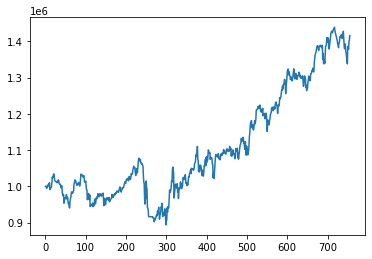

In [31]:
%matplotlib inline
df_account_value.account_value.plot()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [32]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.122900
Cumulative returns     0.415869
Annual volatility      0.159449
Sharpe ratio           0.808013
Calmar ratio           0.719593
Stability              0.794142
Max drawdown          -0.170791
Omega ratio            1.158822
Sortino ratio          1.124166
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.926351
Daily value at risk   -0.019577
dtype: float64


In [33]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (755, 8)
Annual return          0.098944
Cumulative returns     0.326674
Annual volatility      0.236083
Sharpe ratio           0.519111
Calmar ratio           0.266795
Stability              0.693332
Max drawdown          -0.370862
Omega ratio            1.118903
Sortino ratio          0.714557
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.950961
Daily value at risk   -0.029257
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (755, 8)


Start date,2019-03-07
End date,2022-03-04
Total months,36
,Backtest
Annual return,12.29%
Cumulative returns,41.587%
Annual volatility,15.945%
Sharpe ratio,0.81
Calmar ratio,0.72
Stability,0.79
Max drawdown,-17.079%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,17.08,2020-02-06,2020-05-13,2020-08-27,146
1,9.10,2019-04-05,2019-06-03,2020-01-09,200
2,7.98,2020-09-02,2020-10-30,2020-12-28,84
3,7.03,2022-01-07,2022-02-24,NaT,NaN
4,5.94,2021-04-16,2021-05-12,2021-06-10,40


Stress Events,mean,min,max
New Normal,0.05%,-6.65%,5.12%


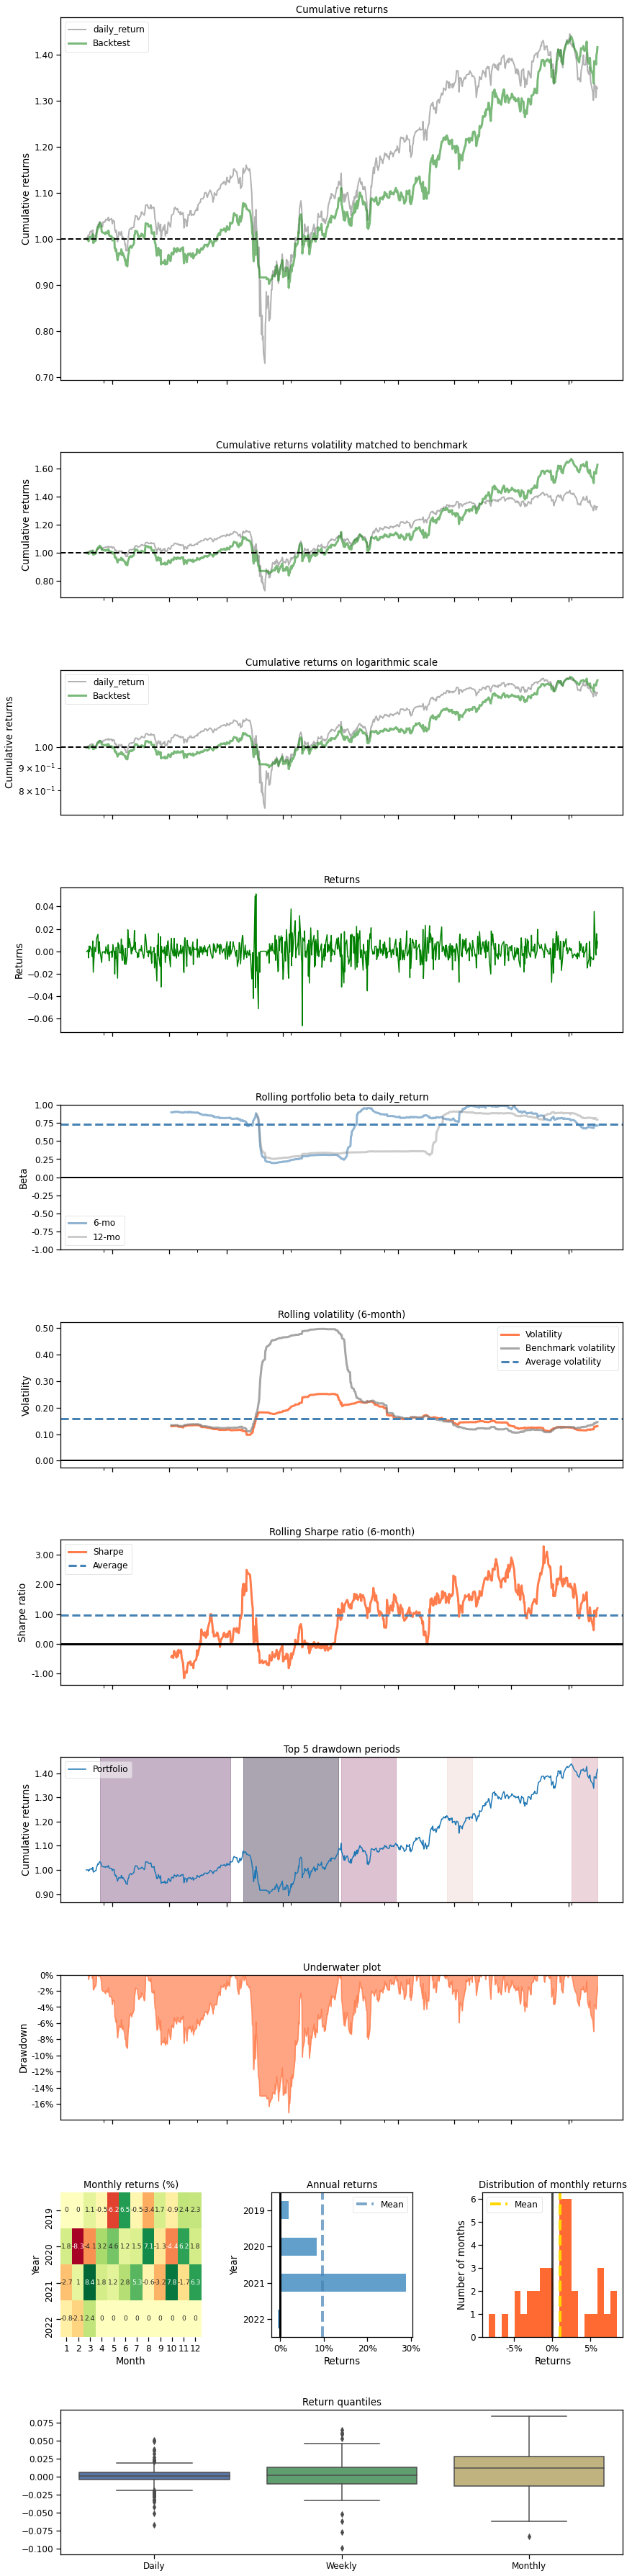

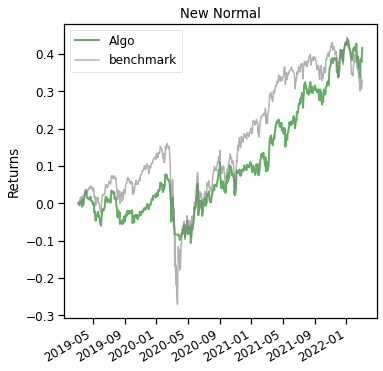

In [34]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])